# Download Image Data from Bucket

In [1]:
import sys
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os
sys.path.append('../src')

from rasterio.enums import Resampling
from skimage.transform import resize

from data_utils import download_tiff_images, display_tiff

# Bucket and directory
bucket_name = 'tree-counting-project'
prefix = 'GEE Dataset/'
local_dir = '../Data/GEE Dataset/Dataset'

# Download images - UNCOMMENT TO DOWLOAD IMAGES FROM BUCKET
# download_tiff_images(bucket_name, prefix, local_dir)

# Display Image

Number of bands in the image: 3
Normalizing image data from float64 to uint8...


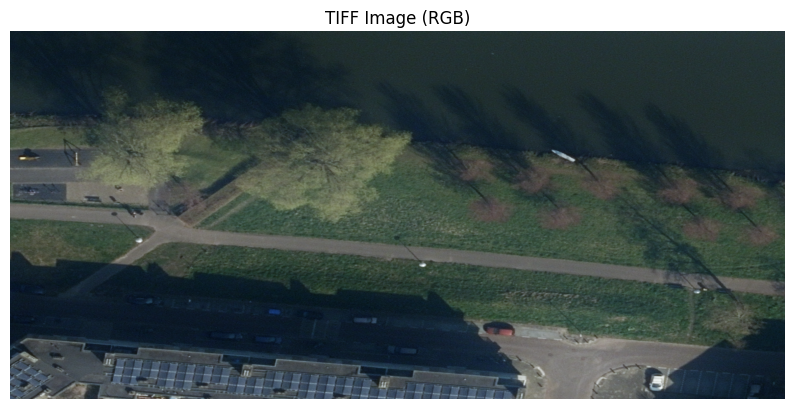

In [25]:
def display_tiff_image(tiff_path):
    with rasterio.open(tiff_path) as src:
        num_bands = src.count
        print(f"Number of bands in the image: {num_bands}")

        # Read the image bands
        bands = [src.read(i) for i in range(1, num_bands + 1)]

        # Convert bands to a stack and normalize
        stacked_image = np.stack(bands, axis=-1)

        # Normalize image if it's not in the range [0, 255]
        if stacked_image.dtype != np.uint8:
            print(f"Normalizing image data from {stacked_image.dtype} to uint8...")
            stacked_image = np.clip(stacked_image, 0, 255)  # Ensure the data is within range
            stacked_image = ((stacked_image - stacked_image.min()) / (stacked_image.max() - stacked_image.min()) * 255).astype(np.uint8)

        # Display single band (grayscale) image
        if num_bands == 1:
            plt.figure(figsize=(10, 10))
            plt.imshow(stacked_image[:, :, 0], cmap='gray')
            plt.title('TIFF Image (Grayscale)')
            plt.axis('off')
            plt.show()

        # Display RGB image
        elif num_bands >= 3:
            plt.figure(figsize=(10, 10))
            plt.imshow(stacked_image[:, :, :3])  # Use first 3 bands for RGB
            plt.title('TIFF Image (RGB)')
            plt.axis('off')
            plt.show()

        # Handle cases with more bands
        else:
            plt.figure(figsize=(10, 10))
            plt.imshow(stacked_image[:, :, :3])  # Using the first 3 bands
            plt.title('TIFF Image (First 3 Bands as RGB)')
            plt.axis('off')
            plt.show()
            
tiff_path = '../Data/GEE Dataset/Dataset/Region_20_Netherlands_2022.tif'
display_tiff_image(tiff_path)


# Converting Geotiff files to PNG for labelling (and Resizing to 640x640)

In [26]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

def normalize(array):
    """Normalizes a numpy array to the range [0, 255]."""
    array_min, array_max = array.min(), array.max()
    if array_max - array_min > 0:
        normalized_array = ((array - array_min) * 255.0 / (array_max - array_min)).astype(np.uint8)
    else:
        normalized_array = np.zeros(array.shape, dtype=np.uint8)  # Handle case where all values are the same
    return normalized_array

def resize_band(band, target_size=(640, 640)):
    """Resizes a single band to the specified dimensions using anti-aliasing."""
    return resize(band, target_size, anti_aliasing=True, mode='reflect', preserve_range=True)

def convert_geotiff_to_png(input_file, output_file, target_size=(640, 640)):
    """Convert a GeoTIFF image to a resized PNG format."""
    with rasterio.open(input_file) as src:
        # Read the three RGB bands
        band1 = src.read(1)  # Red
        band2 = src.read(2)  # Green
        band3 = src.read(3)  # Blue
        
        # Normalize bands to the range 0-255
        band1_normalized = normalize(band1)
        band2_normalized = normalize(band2)
        band3_normalized = normalize(band3)
        
        # Resize bands to the target dimensions
        band1_resized = resize_band(band1_normalized, target_size)
        band2_resized = resize_band(band2_normalized, target_size)
        band3_resized = resize_band(band3_normalized, target_size)
        
        # Debug: print min/max to check scaling
        print(f"Band1 Min/Max: {band1.min()}/{band1.max()} -> {band1_resized.min()}/{band1_resized.max()}")
        print(f"Band2 Min/Max: {band2.min()}/{band2.max()} -> {band2_resized.min()}/{band2_resized.max()}")
        print(f"Band3 Min/Max: {band3.min()}/{band3.max()} -> {band3_resized.min()}/{band3_resized.max()}")
        
        # Stack resized bands to create an RGB image
        rgb_image = np.dstack((band1_resized, band2_resized, band3_resized)).astype(np.uint8)
        
        # Plot and save the image
        plt.imshow(rgb_image)
        plt.axis('off')  # No axis for a cleaner image
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0)
        plt.close()
        
# File paths
input_directory = '/home/jupyter/ee_tree_counting/Data/GEE Dataset/Dataset'
output_directory = '/home/jupyter/ee_tree_counting/Data/GEE Dataset/PNG'

# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Process each GeoTIFF file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        input_file = os.path.join(input_directory, filename)
        output_file = os.path.join(output_directory, filename.replace('.tif', '.png').replace('.tiff', '.png'))
        
        # Convert the file
        convert_geotiff_to_png(input_file, output_file)
        
        print(f'Converted {filename} to PNG.')


Band1 Min/Max: 28.0/219.5 -> 0.0/254.4374998862915
Band2 Min/Max: 45.5/210.0 -> 0.0/253.9124999224477
Band3 Min/Max: 46.0/212.5 -> 0.0697436528099368/254.12499967964183
Converted Region_1_Latvia_RGB.tif to PNG.
Band1 Min/Max: 0.0/249.0 -> 1.287499999999909/251.94751953124995
Band2 Min/Max: 2.0/255.0 -> 0.8904968261720128/253.2697619628906
Band3 Min/Max: 0.0/255.0 -> 0.6421874999999488/254.97933837890622
Converted Region_1_switzerland.tif to PNG.
Band1 Min/Max: 18.0/253.0 -> 2.2327882991852697/252.1890288255864
Band2 Min/Max: 30.0/251.0 -> 1.8323020785432904/253.5329471267455
Band3 Min/Max: 31.0/250.0 -> 1.9542389576930312/254.10806935105455
Converted Region_13_Netherlands_2022.tif to PNG.
Band1 Min/Max: 27.0/254.0 -> 1.8114479779987855/254.99999999999997
Band2 Min/Max: 32.0/254.0 -> 3.5507259775789084/254.99999999999997
Band3 Min/Max: 29.0/254.0 -> 3.1473469020416807/254.99999999999997
Converted Region_9_Netherlands_2021.tif to PNG.
Band1 Min/Max: 34.0/241.0 -> 1.0285878976811738/254.1